# ASSIGNMENT 6, QUESTION 2 
### FACIAL RECOGNITION USING LINEAR DISCRIMINANT ANALYSIS 
In this assignment, we use the data collected from us and 9 of our friends in order to evaluate the accuracy of the LDA approach for detecting faces. This has a number of security and authentication applications, especially in devices which have limited computational resources. 

In [96]:
import PIL 
import imageio as im
import numpy as np 
import pandas as pd 
import os, sys, glob
import matplotlib.pyplot as plt
import matplotlib.image as image
import copy

### Preprocessing the data

The data size in this case is 4000x3000, obtained from a mobile phone camera. To make it reasonably quick, we reduce the quality of the image to around 128x128 pixels, but leave the color information intact. This is done in order to increase the chances of small facial features helping in the recognition process of the faces. 

In [122]:
path = '/Users/bhanubhandari/Downloads/Faces/'
# size = 128, 128

# from PIL import Image
# for infile in glob.glob("*.jpg"):
#     file, ext = os.path.splitext(infile)
#     im1 = Image.open(infile)
#     im1.thumbnail(size)
#     im1.save(file + "_proc.jpg", "JPEG")

face_data = []
face_data_raw = []
for i in range (1,10):
    for j in range (1,5):
        filename = str(path + str(i) +'_' + str(j) + '_proc' + '.jpg')
        temp = im.imread(filename)
        temp[:] = np.max(temp,axis=-1,keepdims=1)/2+np.min(temp,axis=-1,keepdims=1)/2
        face_data_raw.append(temp)
        f = temp.flatten()
        face_data.append(f)
        
train_faces = np.asarray(face_data)

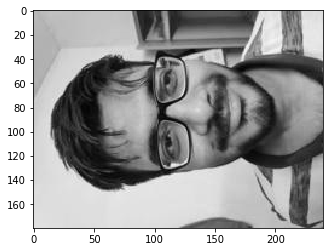

In [123]:
plt.imshow(face_data_raw[1])

(180, 240, 3)


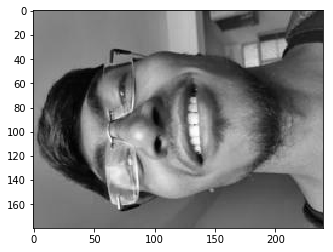

In [124]:
plt.imshow(face_data_raw[25])
print(face_data_raw[0].shape)

### Calculating the mean for further subtracting
This mean is used to convert the distribution into one which has a mean of zero. 

In [125]:
mean = np.mean(train_faces,axis=0)
mean

array([167.38888889, 167.38888889, 167.38888889, ..., 112.69444444,
       112.69444444, 112.69444444])

### Subtracting the mean to get zero mean

In [126]:
for i in range (train_faces.shape[1]):
        for j in range(train_faces.shape[0]):
            train_faces[j][i] = train_faces[j][i] - mean[i]

### Calculating the eigenfaces and weights
This step is the next step in finding out the most important $k$ parts of the image. We use numpy to obtain the eigenvalues and eigenvectors in order to perform the following Linear Discriminant Analysis. 

In [127]:
cov_mat = np.matmul(train_faces,np.transpose(train_faces))
eigval, eigvec = np.linalg.eig(cov_mat)
imp_eig_vec = eigvec[::,0:3]
eig_faces = np.matmul(np.transpose(imp_eig_vec),train_faces)
weights = np.matmul(eig_faces,np.transpose(train_faces))

We now plot a sample eigenface. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


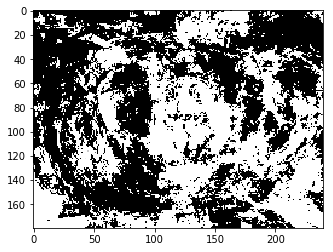

In [128]:
eigen_face = eig_faces[2].reshape(180,240,3)
plt.imshow(eigen_face)

# FISCHER'S LINEAR DISCRIMINANT ANALYSIS
We first obtain the class means for each of the images on which we have performed the analysis. Then, we obtain the within-class scatter and between-class scatter. Then, we use the formulation given by Fischer which uses the above scatter values in order to obtain the Fischer faces. We are also looking for values which give us the maximum separation between the different classes. This is a 10 class division, so the results are not too great - there is definitely some scope for improvement, but given the data quality at hand, the results are satisfactory. 

Retaining color information is not necessarily giving much better results either. 

In [134]:
import scipy.spatial.distance as sp
final_eig_faces = weights
class_means = np.empty([9,2])
all_mean = np.mean(final_eig_faces, axis = 1)

for j in range(9):
    for i in range (int(j*final_eig_faces.shape[1]/9), int((j+1)*final_eig_faces.shape[1]/9)):
        class_means[j][0] = class_means[j][0] + final_eig_faces[0][i]
        class_means[j][1] = class_means[j][1] + final_eig_faces[1][i]

    class_means[j][0] = class_means[j][0]/9
    class_means[j][1] = class_means[j][1]/9
    
facesw = copy.deepcopy(final_eig_faces)
facesb = copy.deepcopy(final_eig_faces)

for i in range (facesb.shape[1]):
    facesb[0][i] = facesb[0][i] - all_mean[0]
    facesb[1][i] = facesb[1][i] - all_mean[1]

for i in range (facesw.shape[1]):
    a = int(i/9)
    facesw[0][i] = facesw[0][i] - class_means[a][0]
    facesw[1][i] = facesw[1][i] - class_means[a][1]
    
s_b = np.matmul(facesb,np.transpose(facesb))
s_w = np.matmul(facesw,np.transpose(facesw))

eigen_value_2, eigen_vector_2 = np.linalg.eig(np.matmul(np.linalg.inv(s_w),s_b))
imp_eig_vec2 = eigen_vector_2[::,-1:]

fisher_faces = np.matmul(np.transpose(imp_eig_vec2),final_eig_faces)

labels = [1,2,3,4,5,6,7,8,9]
correct = np.zeros(9)

for k in range (1,10):
    min_dist = (10)**21
    filename = str(path + str(k) +'_5_proc' + '.jpg')
    temp = im.imread(filename)
    f = temp.flatten()
    test_obj = np.reshape(f,[129600,1])

    for i in range (129600):
        test_obj[i][0] = test_obj[i][0] - mean[i]

    test_face = np.matmul(eig_faces,test_obj)
    test_face_final = np.matmul(np.transpose(imp_eig_vec2),test_face)
    test_face_final = test_face_final[0][0]
    
    for i in range (fisher_faces.shape[1]):
        dist = sp.mahalanobis(fisher_faces[0][i],test_face_final,np.linalg.inv(var))
        if (dist < min_dist):
            min_dist = dist
            min_i = i
        if (labels[k-1] == (min_i//9)+1):
            correct[k-1] = 1
    
    print ("Actual person: " , labels[k-1], "Predicted person:", (min_i//9)+1)
print("Correct predictions are: ", correct)
print("Accuracy = ", sum(correct==1)*11.1111, "%")

Actual person:  1 Predicted person: 1
Actual person:  2 Predicted person: 1
Actual person:  3 Predicted person: 3
Actual person:  4 Predicted person: 3
Actual person:  5 Predicted person: 1
Actual person:  6 Predicted person: 1
Actual person:  7 Predicted person: 3
Actual person:  8 Predicted person: 2
Actual person:  9 Predicted person: 4
Correct predictions are:  [1. 0. 1. 0. 0. 0. 0. 0. 0.]
Accuracy =  22.2222 %


### SUMMARY 
In this assignment, we have completed the process of evaluating the Fischer's LDA for the given self-collected face dataset. This raw data was then processed into a form which is computable in a much faster fashion as compared to the raw data. Further, we obtain weights from the covariance matrix and the class means, using which we got the values of the between-class and within-class scatter. On the basis of these, we were able to find eigenfaces based on the weights calculated earlier, and thus we were able to predict the person whose face was being tested. The accuracy is somewhat better than PCA, but given a better dataset we may be able to achieve a higher accuracy. 